# FPGA Accelerated - Naive Bayes Classification

#### In this notebook we are going to use the **InAccel modified GaussianNB** class to accelerate the algorithm's classification part. We will also use the **original scikit-learn implementation** to compute the overall **speedup** we get and compare any differences in the calculated predictions among the two runs. For the training and classification parts, we are going to create a custom dataset and further on adjust the number of **samples**, **features** and **classes** to inspect who speedup is affected.

### Import all necessary libraries

In [1]:
from inaccel.sklearn.naive_bayes import GaussianNB
import numpy as np
from sklearn import datasets
from sklearn import metrics
from time import time

### Create a custom dataset with the defined number of samples, features and classes

In [2]:
samples = 10000
features = 500
classes = 10

X, y = datasets.make_classification(n_samples = samples, n_features = features, n_informative = 400, n_redundant = 50,
                                    n_repeated = 50, n_classes = classes, class_sep = 10.0, random_state = 0)

### Use only **10%** of the generated samples for the training part and the rest for the classification

In [3]:
# Samples used for training the model
train_samples = int(0.1 * samples)

train_labels = y[:train_samples]
train_features = X[:train_samples]
print("Train data shape:\n\tLabels: " + str(train_labels.shape) + "\n\tFeatures: " + str(train_features.shape))

test_labels = y[train_samples:]
test_features = X[train_samples:]
print("Test data shape:\n\tLabels: " + str(test_labels.shape) + "\n\tFeatures: " + str(test_features.shape))

Train data shape:
	Labels: (1000,)
	Features: (1000, 500)
Test data shape:
	Labels: (9000,)
	Features: (9000, 500)


### Create a Naive Bayes object and **train** a model

In [4]:
nb = GaussianNB()

startTime = time()
nb_model = nb.fit(train_features, train_labels)
elapsedTime = int((time() - startTime) * 100) / 100

print("Naive Bayes training (CPU) took: " + str(elapsedTime) + " sec")

Naive Bayes training (CPU) took: 0.01 sec


### Calculate the predictions using the FPGA resources

In [5]:
startTime = time()
predictions = nb_model.predict(test_features)
elapsedTime = int((time() - startTime) * 100) / 100

print("Accuracy: " + str(int(metrics.accuracy_score(test_labels, predictions) * 10000) / 100) + "%")
print("Naive Bayes classification (FPGA) took: " + str(elapsedTime) + " sec")

Accuracy: 99.13%
Naive Bayes classification (FPGA) took: 0.06 sec


### Import the Original NaiveBayes class to compare the classification part execution time

In [6]:
from sklearn.naive_bayes import GaussianNB as OriginalNB

cpuNB = OriginalNB()

cpu_model = cpuNB.fit(train_features, train_labels)

### Calculate the predictions using the CPU resources

In [7]:
startTimeCPU = time()
predictionsCPU = cpu_model.predict(test_features)
elapsedTimeCPU = int((time() - startTimeCPU) * 100) / 100

print("Accuracy: " + str(int(metrics.accuracy_score(test_labels, predictionsCPU) * 10000) / 100) + "%")
print("Naive Bayes classification (CPU) took: " + str(elapsedTimeCPU) + " sec")

Accuracy: 99.13%
Naive Bayes classification (CPU) took: 0.39 sec


### Speedup Calculation

In [8]:
speedup = int(elapsedTimeCPU / elapsedTime * 100) / 100
print("Speedup: " + str(speedup))

Speedup: 6.5


In [18]:
def naive_bayes(samples, features, classes):
    
    X, y = datasets.make_classification(n_samples = samples, n_features = features, n_informative = 400, n_redundant = 50,
                                    n_repeated = 50, n_classes = classes, class_sep = 10.0, random_state = 0)
    
    # Samples used for training the model
    train_samples = int(0.1 * samples)

    train_labels = y[:train_samples]
    train_features = X[:train_samples]
    print("Train data shape:\n\tLabels: " + str(train_labels.shape) + "\n\tFeatures: " + str(train_features.shape))

    test_labels = y[train_samples:]
    test_features = X[train_samples:]
    print("Test data shape:\n\tLabels: " + str(test_labels.shape) + "\n\tFeatures: " + str(test_features.shape))
    
    nb = GaussianNB()

    startTime = time()
    nb_model = nb.fit(train_features, train_labels)
    elapsedTime = int((time() - startTime) * 100) / 100

    print("Naive Bayes training (CPU) took: " + str(elapsedTime) + " sec")
    
    startTime = time()
    predictions = nb_model.predict(test_features)
    elapsedTime = int((time() - startTime) * 100) / 100

    print("Accuracy: " + str(int(metrics.accuracy_score(test_labels, predictions) * 10000) / 100) + "%")
    print("Naive Bayes classification (FPGA) took: " + str(elapsedTime) + " sec")
    
    cpuNB = OriginalNB()

    cpu_model = cpuNB.fit(train_features, train_labels)
    
    startTimeCPU = time()
    predictionsCPU = cpu_model.predict(test_features)
    elapsedTimeCPU = int((time() - startTimeCPU) * 100) / 100

    print("Accuracy: " + str(int(metrics.accuracy_score(test_labels, predictionsCPU) * 10000) / 100) + "%")
    print("Naive Bayes classification (CPU) took: " + str(elapsedTimeCPU) + " sec")
    
    speedup = int(elapsedTimeCPU / elapsedTime * 100) / 100
    print("Speedup: " + str(speedup))
    
    return elapsedTime, elapsedTimeCPU, speedup
    

In [19]:
import itertools
from tqdm import tqdm

samples_list  = [100000]
features_list = [500, 1000, 2000]
classes       = [10, 35, 60]

combinations = list(itertools.product(samples_list, features_list, classes))

timesCPU  = {}
timesFPGA = {}
speedups  = {}
for samples, features, classes in tqdm(combinations):
    print(f'samples = {samples}, features = {features}, classes = {classes}')
    timeFPGA, timeCPU, speedup = naive_bayes(samples, features, classes)
    timesCPU[(samples, features, classes)]  = timeCPU
    timesFPGA[(samples, features, classes)] = timeFPGA
    speedups[(samples, features, classes)]  = speedup
    print('-------------------------------------------------------------------')

  0%|          | 0/9 [00:00<?, ?it/s]

samples = 100000, features = 500, classes = 10
Train data shape:
	Labels: (10000,)
	Features: (10000, 500)
Test data shape:
	Labels: (90000,)
	Features: (90000, 500)
Naive Bayes training (CPU) took: 0.09 sec
Accuracy: 99.09%
Naive Bayes classification (FPGA) took: 0.26 sec


 11%|█         | 1/9 [00:11<01:31, 11.46s/it]

Accuracy: 99.09%
Naive Bayes classification (CPU) took: 5.3 sec
Speedup: 20.38
-------------------------------------------------------------------
samples = 100000, features = 500, classes = 35
Train data shape:
	Labels: (10000,)
	Features: (10000, 500)
Test data shape:
	Labels: (90000,)
	Features: (90000, 500)
Naive Bayes training (CPU) took: 0.09 sec
Accuracy: 99.08%
Naive Bayes classification (FPGA) took: 0.3 sec


 22%|██▏       | 2/9 [00:37<02:18, 19.83s/it]

Accuracy: 99.08%
Naive Bayes classification (CPU) took: 19.08 sec
Speedup: 63.59
-------------------------------------------------------------------
samples = 100000, features = 500, classes = 60
Train data shape:
	Labels: (10000,)
	Features: (10000, 500)
Test data shape:
	Labels: (90000,)
	Features: (90000, 500)
Naive Bayes training (CPU) took: 0.12 sec
Accuracy: 98.96%
Naive Bayes classification (FPGA) took: 0.35 sec


 33%|███▎      | 3/9 [01:13<02:42, 27.16s/it]

Accuracy: 98.96%
Naive Bayes classification (CPU) took: 29.55 sec
Speedup: 84.42
-------------------------------------------------------------------
samples = 100000, features = 1000, classes = 10
Train data shape:
	Labels: (10000,)
	Features: (10000, 1000)
Test data shape:
	Labels: (90000,)
	Features: (90000, 1000)
Naive Bayes training (CPU) took: 0.17 sec
Accuracy: 99.06%
Naive Bayes classification (FPGA) took: 0.38 sec


 44%|████▍     | 4/9 [01:30<01:56, 23.20s/it]

Accuracy: 99.06%
Naive Bayes classification (CPU) took: 8.48 sec
Speedup: 22.31
-------------------------------------------------------------------
samples = 100000, features = 1000, classes = 35
Train data shape:
	Labels: (10000,)
	Features: (10000, 1000)
Test data shape:
	Labels: (90000,)
	Features: (90000, 1000)
Naive Bayes training (CPU) took: 0.15 sec
Accuracy: 98.97%
Naive Bayes classification (FPGA) took: 0.4 sec


 56%|█████▌    | 5/9 [02:09<01:56, 29.13s/it]

Accuracy: 98.97%
Naive Bayes classification (CPU) took: 30.13 sec
Speedup: 75.32
-------------------------------------------------------------------
samples = 100000, features = 1000, classes = 60
Train data shape:
	Labels: (10000,)
	Features: (10000, 1000)
Test data shape:
	Labels: (90000,)
	Features: (90000, 1000)
Naive Bayes training (CPU) took: 0.15 sec
Accuracy: 99.0%
Naive Bayes classification (FPGA) took: 0.43 sec


 67%|██████▋   | 6/9 [03:11<02:00, 40.31s/it]

Accuracy: 99.0%
Naive Bayes classification (CPU) took: 53.47 sec
Speedup: 124.34
-------------------------------------------------------------------
samples = 100000, features = 2000, classes = 10
Train data shape:
	Labels: (10000,)
	Features: (10000, 2000)
Test data shape:
	Labels: (90000,)
	Features: (90000, 2000)
Naive Bayes training (CPU) took: 0.34 sec
Accuracy: 99.07%
Naive Bayes classification (FPGA) took: 0.72 sec


 78%|███████▊  | 7/9 [03:44<01:15, 37.75s/it]

Accuracy: 99.07%
Naive Bayes classification (CPU) took: 16.27 sec
Speedup: 22.59
-------------------------------------------------------------------
samples = 100000, features = 2000, classes = 35
Train data shape:
	Labels: (10000,)
	Features: (10000, 2000)
Test data shape:
	Labels: (90000,)
	Features: (90000, 2000)
Naive Bayes training (CPU) took: 0.33 sec
Accuracy: 99.02%
Naive Bayes classification (FPGA) took: 0.77 sec


 89%|████████▉ | 8/9 [05:03<00:50, 50.91s/it]

Accuracy: 99.02%
Naive Bayes classification (CPU) took: 63.98 sec
Speedup: 83.09
-------------------------------------------------------------------
samples = 100000, features = 2000, classes = 60
Train data shape:
	Labels: (10000,)
	Features: (10000, 2000)
Test data shape:
	Labels: (90000,)
	Features: (90000, 2000)
Naive Bayes training (CPU) took: 0.32 sec
Accuracy: 99.05%
Naive Bayes classification (FPGA) took: 0.88 sec


100%|██████████| 9/9 [07:05<00:00, 47.31s/it]

Accuracy: 99.05%
Naive Bayes classification (CPU) took: 106.34 sec
Speedup: 120.84
-------------------------------------------------------------------


In [20]:
speedups

{(100000, 500, 10): 20.38,
 (100000, 500, 35): 63.59,
 (100000, 500, 60): 84.42,
 (100000, 1000, 10): 22.31,
 (100000, 1000, 35): 75.32,
 (100000, 1000, 60): 124.34,
 (100000, 2000, 10): 22.59,
 (100000, 2000, 35): 83.09,
 (100000, 2000, 60): 120.84}

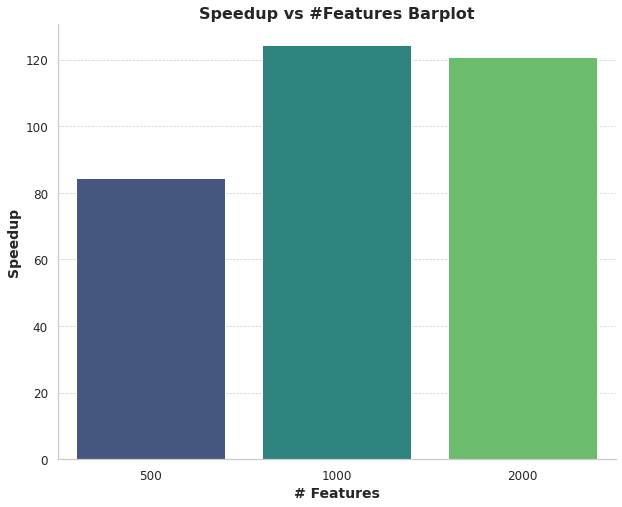

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

plot1values = [speedups[key] for key in speedups if key[0] == 100000 and key[-1] == 60]
plot1labels = [str(f) for f in features_list]

sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))
palette = sns.color_palette("viridis", len(plot1values))

sns.barplot(x=plot1labels, y=plot1values, palette=palette)

plt.xlabel('# Features', fontsize=14, fontweight='bold')
plt.ylabel('Speedup', fontsize=14, fontweight='bold')
plt.title('Speedup vs # Features Barplot', fontsize=16, fontweight='bold')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(axis='y', linestyle='--', linewidth=0.7)

sns.despine()
plt.show()

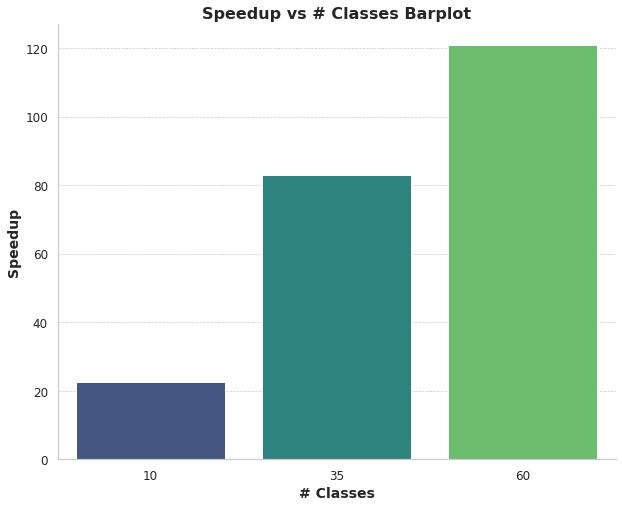

In [36]:
plot2values = [speedups[key] for key in speedups if key[0] == 100000 and key[1] == 2000]
plot2labels = [10, 35, 60]

sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))
palette = sns.color_palette("viridis", len(plot1values))

sns.barplot(x=plot2labels, y=plot2values, palette=palette)

plt.xlabel('# Classes', fontsize=14, fontweight='bold')
plt.ylabel('Speedup', fontsize=14, fontweight='bold')
plt.title('Speedup vs # Classes Barplot', fontsize=16, fontweight='bold')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(axis='y', linestyle='--', linewidth=0.7)

sns.despine()
plt.show()

60